In [5]:
import torch

import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F




In [6]:
# HYPER PARAMETER
captions_path = r"G:\My Drive\IUH's Stuff\DeepLearning\Flickr8k\captions.txt"
images_path = r"C:\Users\asus\Downloads\archive\Images"
random_seed = 42

In [7]:

class ImageCaptionDataset(Dataset):
    def __init__(self, raw_data: dict, transform=None, target_transform=None):
        """
        raw_data: dict[str, list[str]]
        """
        super().__init__()
        self.data = raw_data
        self.transform = transform
        self.target_transform = target_transform
        self.paths = list(raw_data.keys())
        # Flatten: (image_path, caption)
        self.samples = []
        for path, captions in raw_data.items():
            for cap in captions:
                self.samples.append((path, cap))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.paths[idx]
        caption = random.choice(self.data[path])

        image = Image.open(os.path.join(images_path, path)).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, caption


In [8]:
# Hàm hỗ trợ

def split_dataset(captions_path: str):
    raw_data = pd.read_csv(captions_path)

    data = {}
    for path, caption in zip(raw_data["image"], raw_data["caption"]):
        data.setdefault(path, []).append(caption)

    paths = list(data.keys())

    # Step 1: split train (70%) and temp (30%)
    train_paths, temp_paths = train_test_split(
        paths,
        test_size=0.3,
        random_state=random_seed,
        shuffle=True
    )

    # Step 2: split temp into val (10%) and test (20%)
    val_paths, test_paths = train_test_split(
        temp_paths,
        test_size=2/3,
        random_state=random_seed,
        shuffle=True
    )

    # Build final dicts
    train_data = {p: data[p] for p in train_paths}
    val_data   = {p: data[p] for p in val_paths}
    test_data  = {p: data[p] for p in test_paths}

    return train_data, val_data, test_data, data


image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

transform_keep_ratio = transforms.Compose([
    transforms.Resize(224),          # cạnh ngắn = 224
    transforms.CenterCrop(224),       # cắt giữa
    transforms.ToTensor(),
])


In [9]:
train_data, val_data, test_data, data = split_dataset(captions_path)
trainDataset = ImageCaptionDataset(train_data, transform_keep_ratio)
valDataset = ImageCaptionDataset(val_data, transform_keep_ratio)
testDataset = ImageCaptionDataset(test_data)

In [10]:
# Visualize data
# Số lượng caption cho mỗi ảnh
captions_size = np.array([len(data[x]) for x in data])
print(captions_size)
print(np.unique(captions_size))


[5 5 5 ... 5 5 5]
[5]


Analyzing image sizes:   0%|          | 0/8091 [00:00<?, ?it/s]

Analyzing image sizes: 100%|██████████| 8091/8091 [01:48<00:00, 74.64it/s]


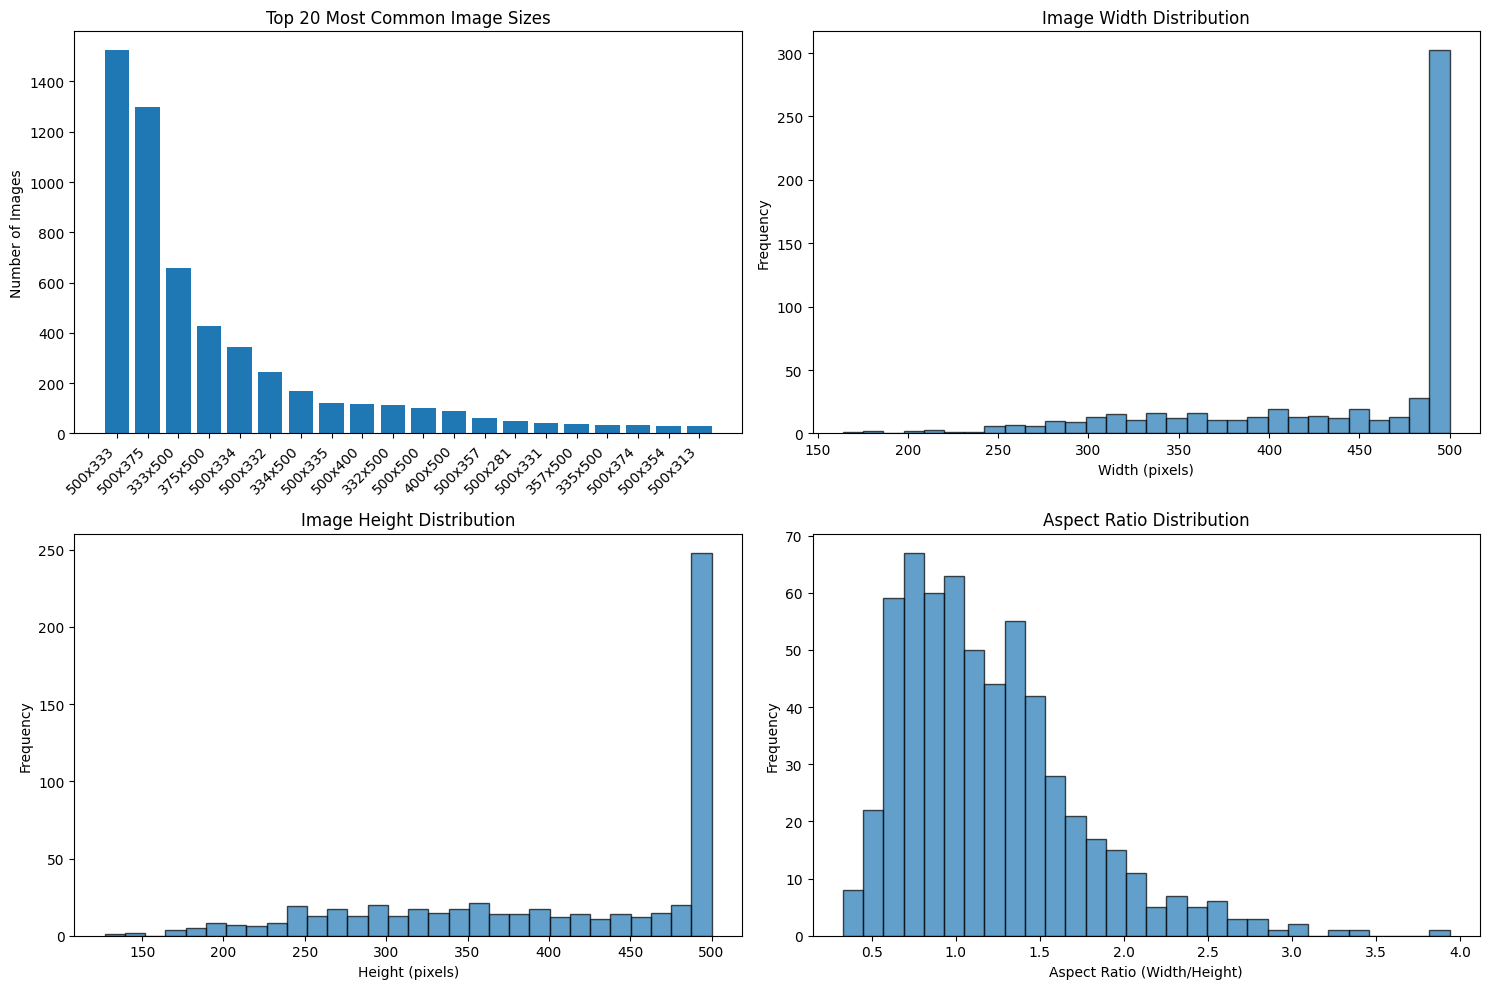

Tổng số kích thước khác nhau: 597
Tổng số ảnh: 8091


In [11]:

images_size = {}
for image_path in tqdm(data.keys(), desc="Analyzing image sizes"):
    with Image.open(os.path.join(images_path, image_path)) as img:
        size = img.size  # (width, height)

    if size in images_size:
        images_size[size] += 1
    else:
        images_size[size] = 1

# Tạo visualization
plt.figure(figsize=(15, 10))

# Subplot 1: Top 20 most common sizes
plt.subplot(2, 2, 1)
sorted_sizes = sorted(images_size.items(), key=lambda x: x[1], reverse=True)[:20]
sizes_labels = [f"{size[0]}x{size[1]}" for size, count in sorted_sizes]
counts = [count for size, count in sorted_sizes]

plt.bar(range(len(sizes_labels)), counts)
plt.xticks(range(len(sizes_labels)), sizes_labels, rotation=45, ha='right')
plt.title('Top 20 Most Common Image Sizes')
plt.ylabel('Number of Images')
plt.tight_layout()

# Subplot 2: Width distribution
plt.subplot(2, 2, 2)
widths = [size[0] for size in images_size.keys()]
plt.hist(widths, bins=30, alpha=0.7, edgecolor='black')
plt.title('Image Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Subplot 3: Height distribution
plt.subplot(2, 2, 3)
heights = [size[1] for size in images_size.keys()]
plt.hist(heights, bins=30, alpha=0.7, edgecolor='black')
plt.title('Image Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

# Subplot 4: Aspect ratio distribution
plt.subplot(2, 2, 4)
aspect_ratios = [size[0]/size[1] for size in images_size.keys()]
plt.hist(aspect_ratios, bins=30, alpha=0.7, edgecolor='black')
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Tổng số kích thước khác nhau: {len(images_size)}")
print(f"Tổng số ảnh: {sum(images_size.values())}")


Ảnh gốc:


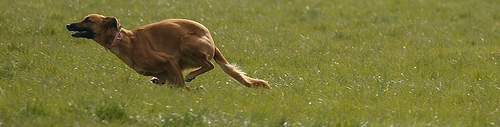

Kích thước: 500x127
Aspect ratio: 3.94


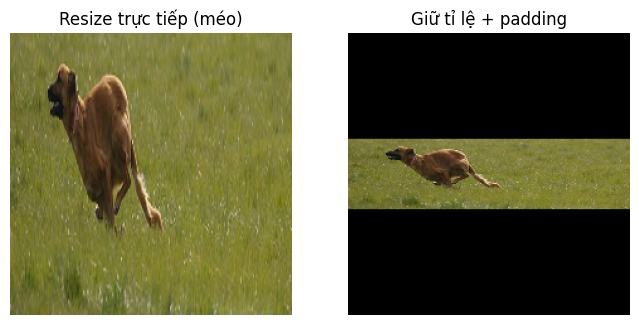

Tensor resize trực tiếp: torch.Size([3, 224, 224])
Tensor padding: torch.Size([3, 224, 224])
Mean absolute difference: 0.3118


In [12]:
# Tìm ảnh có aspect ratio lớn nhất
max_aspect_ratio = 0
max_aspect_image = None
max_image_path = None

for size in images_size.keys():
    aspect_ratio = size[0] / size[1]  # width / height
    if aspect_ratio > max_aspect_ratio:
        max_aspect_ratio = aspect_ratio
        max_aspect_image = size

# Tìm ảnh có aspect ratio lớn nhất và hiển thị + resize
for image_path in data.keys():
    with Image.open(os.path.join(images_path, image_path)) as img:
        current_size = img.size
        if current_size == max_aspect_image:
            print("Ảnh gốc:")
            display(img)
            max_image_path = os.path.join(images_path, image_path)
            break

print(f"Kích thước: {max_aspect_image[0]}x{max_aspect_image[1]}")
print(f"Aspect ratio: {max_aspect_ratio:.2f}")

# ===== SCALE ẢNH VỀ 224x224 =====
TARGET = 224

# Đọc ảnh bằng cv2
img_cv = cv2.imread(max_image_path)
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# ---- CÁCH 1: Resize trực tiếp (méo ảnh) ----
resize_direct = cv2.resize(img_cv, (TARGET, TARGET))

# ---- CÁCH 2: Giữ tỉ lệ + padding ----
h, w, _ = img_cv.shape
scale = TARGET / max(h, w)
new_w, new_h = int(w * scale), int(h * scale)

resized = cv2.resize(img_cv, (new_w, new_h))
padded = np.zeros((TARGET, TARGET, 3), dtype=np.uint8)

x_offset = (TARGET - new_w) // 2
y_offset = (TARGET - new_h) // 2
padded[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

# ---- Hiển thị ----
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(resize_direct)
plt.title("Resize trực tiếp (méo)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(padded)
plt.title("Giữ tỉ lệ + padding")
plt.axis("off")

plt.show()

# ===== TRANSFORMER + SO SÁNH =====
image_transform = transforms.Compose([
    transforms.ToTensor(),  # 224x224 -> Tensor [3,224,224]
])

# numpy -> PIL -> tensor
tensor_direct = image_transform(Image.fromarray(resize_direct))
tensor_padded = image_transform(Image.fromarray(padded))

# So sánh định lượng
diff = torch.mean(torch.abs(tensor_direct - tensor_padded))

print("Tensor resize trực tiếp:", tensor_direct.shape)
print("Tensor padding:", tensor_padded.shape)
print(f"Mean absolute difference: {diff.item():.4f}")



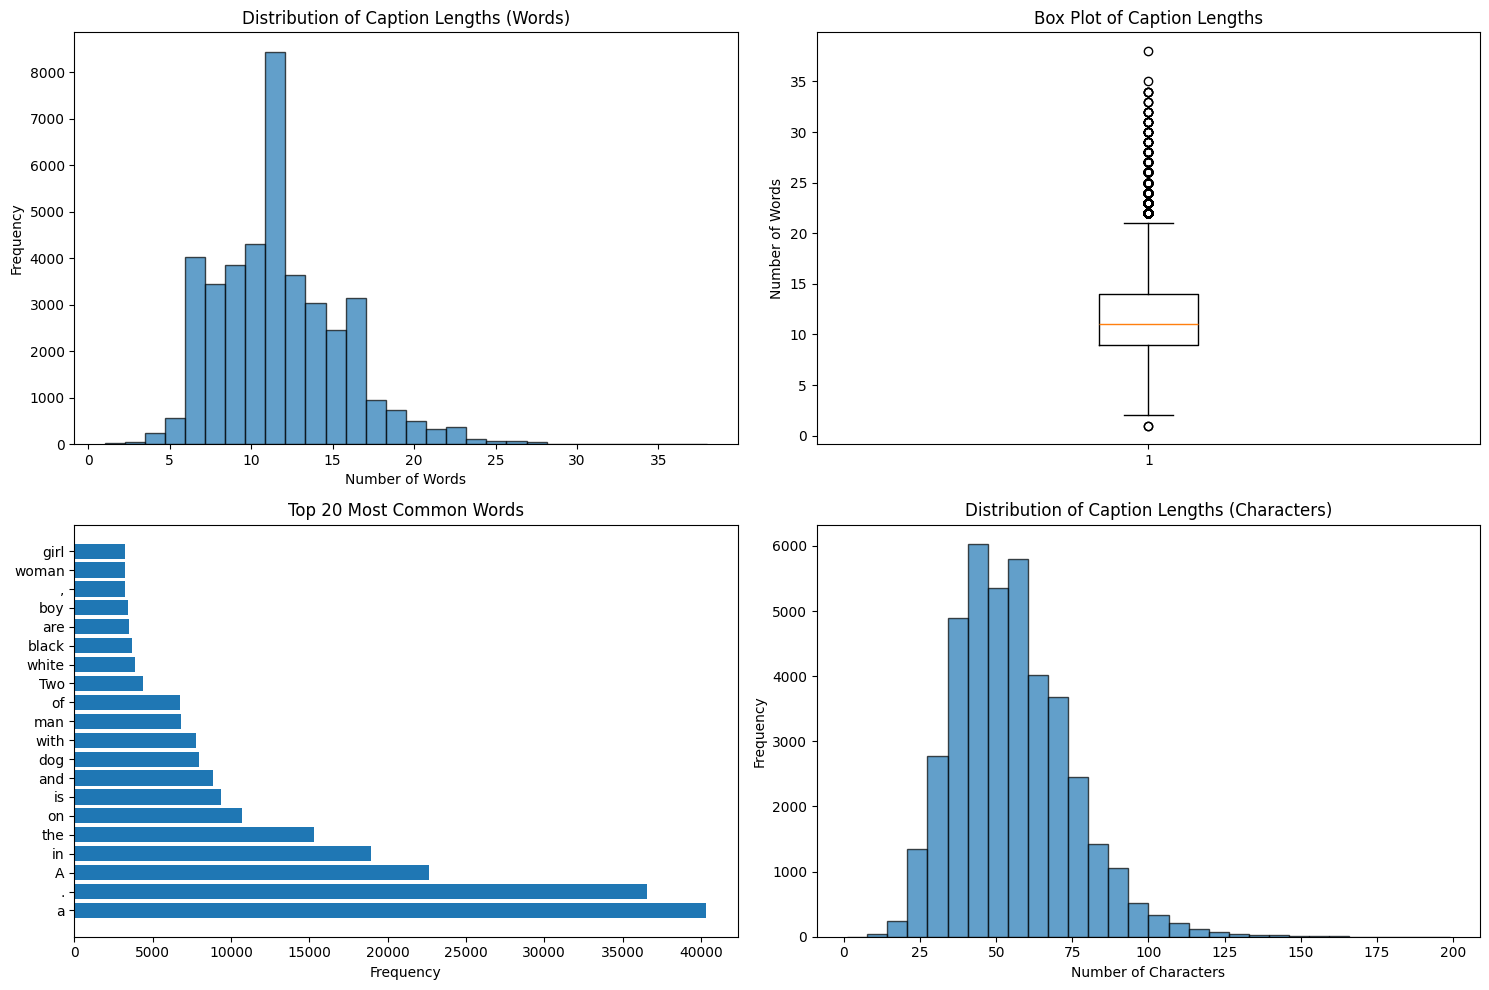

Tổng số caption: 40455
Độ dài caption trung bình (từ): 11.78
Độ dài caption ngắn nhất: 1 từ
Độ dài caption dài nhất: 38 từ
Độ dài caption trung vị: 11.00 từ
Tổng số từ duy nhất: 9630
Tổng số từ: 476665


In [13]:
# Tạo danh sách tất cả các caption
all_captions = []
for captions_list in data.values():
    all_captions.extend(captions_list)

# Tính độ dài câu (số từ)
caption_lengths = [len(caption.split()) for caption in all_captions]

# Visualization
plt.figure(figsize=(15, 10))

# Subplot 1: Histogram của độ dài caption
plt.subplot(2, 2, 1)
plt.hist(caption_lengths, bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribution of Caption Lengths (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Subplot 2: Box plot
plt.subplot(2, 2, 2)
plt.boxplot(caption_lengths)
plt.title('Box Plot of Caption Lengths')
plt.ylabel('Number of Words')

# Subplot 3: Số lượng từ duy nhất trong các caption
all_words = ' '.join(all_captions).split()
unique_words = set(all_words)
word_freq = {}
for word in all_words:
    word_freq[word] = word_freq.get(word, 0) + 1

# Top 20 từ phổ biến nhất
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
words, frequencies = zip(*sorted_words)

plt.subplot(2, 2, 3)
plt.barh(range(len(words)), frequencies)
plt.yticks(range(len(words)), words)
plt.title('Top 20 Most Common Words')
plt.xlabel('Frequency')

# Subplot 4: Độ dài ký tự của caption
caption_char_lengths = [len(caption) for caption in all_captions]
plt.subplot(2, 2, 4)
plt.hist(caption_char_lengths, bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribution of Caption Lengths (Characters)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# In thống kê
print(f"Tổng số caption: {len(all_captions)}")
print(f"Độ dài caption trung bình (từ): {np.mean(caption_lengths):.2f}")
print(f"Độ dài caption ngắn nhất: {min(caption_lengths)} từ")
print(f"Độ dài caption dài nhất: {max(caption_lengths)} từ")
print(f"Độ dài caption trung vị: {np.median(caption_lengths):.2f} từ")
print(f"Tổng số từ duy nhất: {len(unique_words)}")
print(f"Tổng số từ: {len(all_words)}")

# Xây dựng Vocabulary (Tokenizer)
Tạo bộ từ điển để chuyển đổi caption thành chuỗi số (token) và ngược lại.

In [14]:
class Vocabulary:
    """Vocabulary để chuyển đổi text thành indices và ngược lại"""

    def __init__(self, freq_threshold=2):
        # Special tokens
        self.PAD_token = "<PAD>"
        self.SOS_token = "<SOS>"  # Start of sentence
        self.EOS_token = "<EOS>"  # End of sentence
        self.UNK_token = "<UNK>"  # Unknown word

        self.freq_threshold = freq_threshold

        # Mappings
        self.word2idx = {
            self.PAD_token: 0,
            self.SOS_token: 1,
            self.EOS_token: 2,
            self.UNK_token: 3
        }
        self.idx2word = {v: k for k, v in self.word2idx.items()}
        self.word_freq = {}

    def __len__(self):
        return len(self.word2idx)

    def build_vocabulary(self, captions_list):
        """Xây dựng vocabulary từ danh sách captions"""
        # Đếm tần suất từ
        for caption in captions_list:
            for word in self.tokenize(caption):
                self.word_freq[word] = self.word_freq.get(word, 0) + 1

        # Thêm từ có tần suất >= threshold vào vocabulary
        idx = len(self.word2idx)
        for word, freq in self.word_freq.items():
            if freq >= self.freq_threshold:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

        print(f"Vocabulary size: {len(self.word2idx)}")
        print(f"Total unique words: {len(self.word_freq)}")
        print(f"Words with freq >= {self.freq_threshold}: {len(self.word2idx) - 4}")

    def tokenize(self, text):
        """Tokenize text thành list of words (lowercase)"""
        # Đơn giản: lowercase và split theo space
        # Có thể thêm xử lý punctuation nếu cần
        text = text.lower().strip()
        # Loại bỏ dấu câu đơn giản
        for char in '.,!?;:"\'()[]{}':
            text = text.replace(char, ' ')
        return text.split()

    def numericalize(self, caption):
        """Chuyển caption thành list of indices với SOS và EOS"""
        tokens = self.tokenize(caption)
        indices = [self.word2idx[self.SOS_token]]

        for token in tokens:
            if token in self.word2idx:
                indices.append(self.word2idx[token])
            else:
                indices.append(self.word2idx[self.UNK_token])

        indices.append(self.word2idx[self.EOS_token])
        return indices

    def denumericalize(self, indices):
        """Chuyển list of indices thành caption string"""
        words = []
        for idx in indices:
            if isinstance(idx, torch.Tensor):
                idx = idx.item()
            word = self.idx2word.get(idx, self.UNK_token)
            if word == self.EOS_token:
                break
            if word not in [self.PAD_token, self.SOS_token]:
                words.append(word)
        return ' '.join(words)

In [15]:
# Tạo vocabulary từ toàn bộ captions
vocab = Vocabulary(freq_threshold=2)
vocab.build_vocabulary(all_captions)

print(f"\nVí dụ numericalize:")
sample_caption = all_captions[0]
print(f"Caption: {sample_caption}")
print(f"Indices: {vocab.numericalize(sample_caption)}")
print(f"Decoded: {vocab.denumericalize(vocab.numericalize(sample_caption))}")

Vocabulary size: 5231
Total unique words: 8904
Words with freq >= 2: 5227

Ví dụ numericalize:
Caption: A child in a pink dress is climbing up a set of stairs in an entry way .
Indices: [1, 4, 5, 6, 4, 7, 8, 9, 10, 11, 4, 12, 13, 14, 6, 15, 3, 16, 2]
Decoded: a child in a pink dress is climbing up a set of stairs in an <UNK> way


# Cập nhật Dataset với Vocabulary
Cập nhật Dataset để trả về caption dưới dạng tensor đã được numericalize.

In [16]:
class ImageCaptionDatasetV2(Dataset):
    """Dataset trả về image tensor và caption tensor đã numericalize"""

    def __init__(self, raw_data: dict, vocab: Vocabulary, transform=None):
        super().__init__()
        self.data = raw_data
        self.vocab = vocab
        self.transform = transform

        # Flatten: (image_path, caption)
        self.samples = []
        for path, captions in raw_data.items():
            for cap in captions:
                self.samples.append((path, cap))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, caption = self.samples[idx]

        # Load và transform image
        image = Image.open(os.path.join(images_path, image_path)).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Numericalize caption
        caption_indices = self.vocab.numericalize(caption)
        caption_tensor = torch.tensor(caption_indices, dtype=torch.long)

        return image, caption_tensor


def collate_fn(batch):
    """
    Custom collate function để pad các caption có độ dài khác nhau
    """
    images, captions = zip(*batch)

    # Stack images thành batch
    images = torch.stack(images, dim=0)

    # Pad captions
    caption_lengths = [len(cap) for cap in captions]
    max_length = max(caption_lengths)

    # Tạo padded tensor
    padded_captions = torch.zeros(len(captions), max_length, dtype=torch.long)
    for i, cap in enumerate(captions):
        padded_captions[i, :len(cap)] = cap

    # Chuyển lengths thành tensor
    lengths = torch.tensor(caption_lengths, dtype=torch.long)

    return images, padded_captions, lengths

In [17]:
# Tạo datasets và dataloaders mới
BATCH_SIZE = 32

train_dataset = ImageCaptionDatasetV2(train_data, vocab, transform_keep_ratio)
val_dataset = ImageCaptionDatasetV2(val_data, vocab, transform_keep_ratio)
test_dataset = ImageCaptionDatasetV2(test_data, vocab, transform_keep_ratio)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train samples: 28315
Val samples: 4045
Test samples: 8095
Train batches: 885
Val batches: 127


In [18]:
# Test một batch từ dataloader
images, captions, lengths = next(iter(train_loader))
print(f"Images shape: {images.shape}")
print(f"Captions shape: {captions.shape}")
print(f"Lengths: {lengths[:5]}")
print(f"\nSample caption indices: {captions[0][:lengths[0]]}")
print(f"Decoded caption: {vocab.denumericalize(captions[0])}")

Images shape: torch.Size([32, 3, 224, 224])
Captions shape: torch.Size([32, 27])
Lengths: tensor([ 9,  6, 14, 12, 14])

Sample caption indices: tensor([  1,   4,  22,  17, 555,  19,   4, 471,   2])
Decoded caption: a little girl sliding into a pool


# Xây dựng Model: CNN Encoder + LSTM Decoder

## 1. CNN Encoder (ResNet-18 Pretrained)
- Sử dụng ResNet-18 pretrained trên ImageNet
- Loại bỏ FC layer cuối, thay bằng một fully connected layer để project feature về embedding size

## 2. LSTM Decoder
- Nhận image embedding làm hidden state khởi tạo
- Sử dụng teacher forcing trong quá trình training
- Output: distribution over vocabulary tại mỗi timestep

In [19]:
class EncoderCNN(nn.Module):
    """
    CNN Encoder sử dụng ResNet-18 pretrained
    Output: Feature vector có kích thước embed_size
    """

    def __init__(self, embed_size=256, train_cnn=False):
        super(EncoderCNN, self).__init__()

        # Load ResNet-18 pretrained
        self.resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

        # Freeze hoặc unfreeze CNN layers
        for param in self.resnet.parameters():
            param.requires_grad = train_cnn

        # Thay thế FC layer cuối
        # ResNet-18 fc layer: (512, 1000) -> thay bằng (512, embed_size)
        in_features = self.resnet.fc.in_features  # 512
        self.resnet.fc = nn.Linear(in_features, embed_size)

        # FC layer mới cần được train
        for param in self.resnet.fc.parameters():
            param.requires_grad = True

        self.bn = nn.BatchNorm1d(embed_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        """
        Args:
            images: (batch_size, 3, 224, 224)
        Returns:
            features: (batch_size, embed_size)
        """
        features = self.resnet(images)  # (batch_size, embed_size)
        features = self.bn(features)
        features = self.dropout(features)
        return features

In [20]:
class DecoderLSTM(nn.Module):
    """
    LSTM Decoder với Teacher Forcing
    Nhận image features và generate caption
    """

    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.5):
        super(DecoderLSTM, self).__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        # Word embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)

        # LSTM
        self.lstm = nn.LSTM(
            input_size=embed_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # FC layer để project hidden state về vocabulary size
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

        # Layer để chuyển image features thành hidden state khởi tạo
        self.init_h = nn.Linear(embed_size, hidden_size)
        self.init_c = nn.Linear(embed_size, hidden_size)

    def init_hidden(self, features):
        """
        Khởi tạo hidden state từ image features
        Args:
            features: (batch_size, embed_size)
        Returns:
            h0: (num_layers, batch_size, hidden_size)
            c0: (num_layers, batch_size, hidden_size)
        """
        batch_size = features.size(0)

        h0 = self.init_h(features)  # (batch_size, hidden_size)
        c0 = self.init_c(features)  # (batch_size, hidden_size)

        # Expand cho num_layers
        h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)  # (num_layers, batch_size, hidden_size)
        c0 = c0.unsqueeze(0).repeat(self.num_layers, 1, 1)

        return h0, c0

    def forward(self, features, captions):
        """
        Forward pass với Teacher Forcing
        Args:
            features: (batch_size, embed_size) - từ encoder
            captions: (batch_size, seq_len) - ground truth captions (bao gồm <SOS>, không bao gồm <EOS> ở input)
        Returns:
            outputs: (batch_size, seq_len, vocab_size) - logits cho mỗi timestep
        """
        batch_size = features.size(0)

        # Khởi tạo hidden state từ image features
        h, c = self.init_hidden(features)

        # Embed captions (bỏ <EOS> token ở cuối để làm input)
        # Input: [<SOS>, w1, w2, ..., wn]
        # Target: [w1, w2, ..., wn, <EOS>]
        embeddings = self.embedding(captions[:, :-1])  # (batch_size, seq_len-1, embed_size)
        embeddings = self.dropout(embeddings)

        # LSTM forward
        lstm_out, (h, c) = self.lstm(embeddings, (h, c))  # (batch_size, seq_len-1, hidden_size)

        # Project to vocabulary
        outputs = self.fc(lstm_out)  # (batch_size, seq_len-1, vocab_size)

        return outputs

    def generate(self, features, max_length=50, vocab=None):
        """
        Generate caption cho một ảnh (inference mode, không dùng teacher forcing)
        Args:
            features: (1, embed_size) hoặc (batch_size, embed_size)
            max_length: độ dài tối đa của caption
            vocab: vocabulary object để lấy special tokens
        Returns:
            generated_ids: list of word indices
        """
        batch_size = features.size(0)

        # Khởi tạo hidden state
        h, c = self.init_hidden(features)

        # Bắt đầu với <SOS> token
        sos_idx = vocab.word2idx[vocab.SOS_token] if vocab else 1
        eos_idx = vocab.word2idx[vocab.EOS_token] if vocab else 2

        current_word = torch.tensor([[sos_idx]] * batch_size, device=features.device)  # (batch_size, 1)

        generated_ids = []

        for _ in range(max_length):
            embeddings = self.embedding(current_word)  # (batch_size, 1, embed_size)
            lstm_out, (h, c) = self.lstm(embeddings, (h, c))  # (batch_size, 1, hidden_size)
            outputs = self.fc(lstm_out.squeeze(1))  # (batch_size, vocab_size)

            # Lấy word có probability cao nhất
            predicted = outputs.argmax(dim=1)  # (batch_size,)
            generated_ids.append(predicted.item() if batch_size == 1 else predicted)

            # Nếu generate <EOS>, dừng lại
            if batch_size == 1 and predicted.item() == eos_idx:
                break

            current_word = predicted.unsqueeze(1)  # (batch_size, 1)

        return generated_ids

In [21]:
class ImageCaptioningModel(nn.Module):
    """
    Mô hình Image Captioning hoàn chỉnh: Encoder + Decoder
    """

    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, train_cnn=False):
        super(ImageCaptioningModel, self).__init__()

        self.encoder = EncoderCNN(embed_size, train_cnn=train_cnn)
        self.decoder = DecoderLSTM(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        """
        Forward pass với teacher forcing
        Args:
            images: (batch_size, 3, 224, 224)
            captions: (batch_size, seq_len)
        Returns:
            outputs: (batch_size, seq_len-1, vocab_size)
        """
        features = self.encoder(images)  # (batch_size, embed_size)
        outputs = self.decoder(features, captions)  # (batch_size, seq_len-1, vocab_size)
        return outputs

    def generate_caption(self, image, vocab, max_length=50):
        """
        Generate caption cho một ảnh
        Args:
            image: (1, 3, 224, 224) hoặc (3, 224, 224)
            vocab: Vocabulary object
            max_length: độ dài tối đa
        Returns:
            caption: string
        """
        self.eval()
        with torch.no_grad():
            if image.dim() == 3:
                image = image.unsqueeze(0)

            features = self.encoder(image)
            generated_ids = self.decoder.generate(features, max_length, vocab)
            caption = vocab.denumericalize(generated_ids)

        return caption

In [22]:
# Khởi tạo model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1
VOCAB_SIZE = len(vocab)
LEARNING_RATE = 3e-4
NUM_EPOCHS = 5

# Tạo model
model = ImageCaptioningModel(
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    train_cnn=False  # Freeze CNN ban đầu
).to(device)

print(f"\nModel Summary:")
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Embed size: {EMBED_SIZE}")
print(f"Hidden size: {HIDDEN_SIZE}")
print(f"Num LSTM layers: {NUM_LAYERS}")

# Đếm parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cuda

Model Summary:
Vocabulary size: 5231
Embed size: 256
Hidden size: 512
Num LSTM layers: 1

Total parameters: 17,171,119
Trainable parameters: 5,994,607


# Training Loop
Huấn luyện model với:
- Cross-Entropy Loss (ignore padding token)
- Teacher Forcing
- Adam optimizer

In [23]:
def train_epoch(model, dataloader, criterion, optimizer, device, vocab):
    """
    Train một epoch
    """
    model.train()
    total_loss = 0
    num_batches = 0

    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for images, captions, lengths in progress_bar:
        images = images.to(device)
        captions = captions.to(device)

        # Forward pass
        # outputs: (batch_size, seq_len-1, vocab_size)
        outputs = model(images, captions)

        # Tính loss
        # Target: captions[:, 1:] - bỏ <SOS>, giữ <EOS>
        targets = captions[:, 1:]  # (batch_size, seq_len-1)

        # Reshape cho CrossEntropyLoss
        # outputs: (batch_size * (seq_len-1), vocab_size)
        # targets: (batch_size * (seq_len-1),)
        outputs = outputs.reshape(-1, outputs.size(-1))
        targets = targets.reshape(-1)

        loss = criterion(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping để tránh exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = total_loss / num_batches
    return avg_loss


def validate(model, dataloader, criterion, device, vocab):
    """
    Validate model trên validation set
    """
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for images, captions, lengths in tqdm(dataloader, desc="Validating", leave=False):
            images = images.to(device)
            captions = captions.to(device)

            # Forward pass
            outputs = model(images, captions)

            # Tính loss
            targets = captions[:, 1:]
            outputs = outputs.reshape(-1, outputs.size(-1))
            targets = targets.reshape(-1)

            loss = criterion(outputs, targets)

            total_loss += loss.item()
            num_batches += 1

    avg_loss = total_loss / num_batches
    return avg_loss


def generate_sample_captions(model, dataloader, vocab, device, num_samples=3):
    """
    Generate và hiển thị sample captions
    """
    model.eval()

    # Lấy một batch
    images, captions, lengths = next(iter(dataloader))

    print("\n" + "="*60)
    print("Sample Generated Captions:")
    print("="*60)

    for i in range(min(num_samples, len(images))):
        image = images[i:i+1].to(device)

        # Generate caption
        generated_caption = model.generate_caption(image, vocab, max_length=30)

        # Ground truth caption
        gt_caption = vocab.denumericalize(captions[i])

        print(f"\nSample {i+1}:")
        print(f"  Ground Truth: {gt_caption}")
        print(f"  Generated:    {generated_caption}")

In [24]:
# Loss và Optimizer
# Ignore padding index (0) trong loss calculation
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx[vocab.PAD_token])
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

print("Optimizer và Loss function đã sẵn sàng!")

Optimizer và Loss function đã sẵn sàng!


In [25]:
# ===================== TRAINING =====================
print("="*60)
print("BẮT ĐẦU HUẤN LUYỆN")
print("="*60)
print(f"Device: {device}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print("="*60)

train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
    print("-" * 40)

    # Training
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device, vocab)
    train_losses.append(train_loss)

    # Validation
    val_loss = validate(model, val_loader, criterion, device, vocab)
    val_losses.append(val_loss)

    # Update learning rate
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, 'best_model.pth')
        print("✓ Saved best model!")

    # Generate sample captions
    generate_sample_captions(model, val_loader, vocab, device, num_samples=2)

print("\n" + "="*60)
print("HUẤN LUYỆN HOÀN TẤT!")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print("="*60)

BẮT ĐẦU HUẤN LUYỆN
Device: cuda
Epochs: 5
Batch size: 32
Learning rate: 0.0003

Epoch [1/5]
----------------------------------------


Train Loss: 4.3329
Val Loss: 3.6960
Learning Rate: 0.000270
✓ Saved best model!

Sample Generated Captions:

Sample 1:
  Ground Truth: a group of people stand outside at night talking
  Generated:    a group of people are standing in a red and white and white and white and white and white dog is standing on a red

Sample 2:
  Ground Truth: a group of people stand on a balcony at nighttime
  Generated:    a group of people are standing in a red and white and white and white and white and white dog is standing on a red

Epoch [2/5]
----------------------------------------


Train Loss: 3.5136
Val Loss: 3.3940
Learning Rate: 0.000243
✓ Saved best model!

Sample Generated Captions:

Sample 1:
  Ground Truth: a group of people stand outside at night talking
  Generated:    a group of people are standing in a crowd of people

Sample 2:
  Ground Truth: a group of people stand on a balcony at nighttime
  Generated:    a group of people are standing in a crowd of people

Epoch [3/5]
----------------------------------------


Train Loss: 3.2427
Val Loss: 3.2577
Learning Rate: 0.000219
✓ Saved best model!

Sample Generated Captions:

Sample 1:
  Ground Truth: a group of people stand outside at night talking
  Generated:    a group of people are standing in front of a building

Sample 2:
  Ground Truth: a group of people stand on a balcony at nighttime
  Generated:    a group of people are standing in front of a building

Epoch [4/5]
----------------------------------------


Train Loss: 3.0783
Val Loss: 3.1762
Learning Rate: 0.000197
✓ Saved best model!

Sample Generated Captions:

Sample 1:
  Ground Truth: a group of people stand outside at night talking
  Generated:    a group of people are standing in front of a building

Sample 2:
  Ground Truth: a group of people stand on a balcony at nighttime
  Generated:    a group of people are standing in front of a building

Epoch [5/5]
----------------------------------------


Train Loss: 2.9614
Val Loss: 3.1196
Learning Rate: 0.000177
✓ Saved best model!

Sample Generated Captions:

Sample 1:
  Ground Truth: a group of people stand outside at night talking
  Generated:    a group of people are standing in front of a building

Sample 2:
  Ground Truth: a group of people stand on a balcony at nighttime
  Generated:    a group of people are standing in front of a building

HUẤN LUYỆN HOÀN TẤT!
Best Validation Loss: 3.1196


# Visualization và Evaluation
Hiển thị loss curves và đánh giá kết quả trên test set

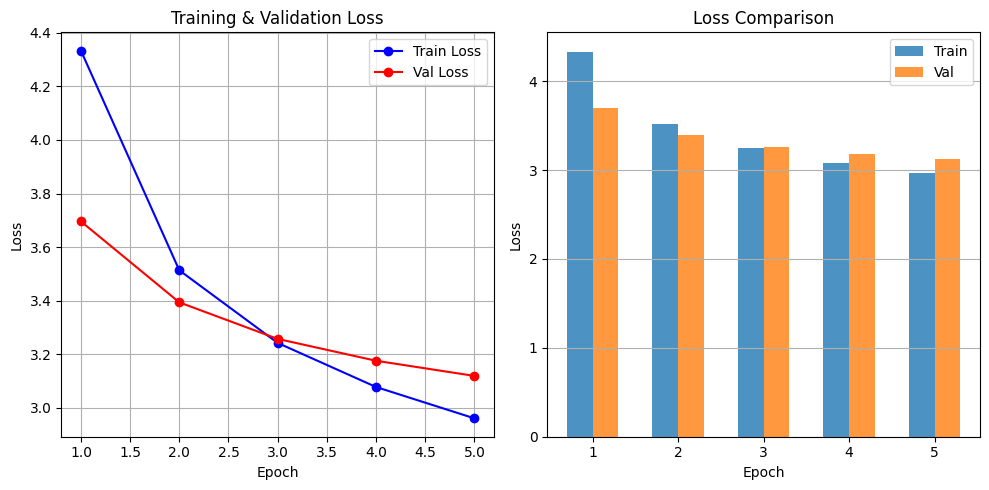

Final Train Loss: 2.9614
Final Val Loss: 3.1196


In [26]:
# Vẽ Loss curves
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-o', label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
epochs = range(1, len(train_losses) + 1)
plt.bar([e - 0.15 for e in epochs], train_losses, width=0.3, label='Train', alpha=0.8)
plt.bar([e + 0.15 for e in epochs], val_losses, width=0.3, label='Val', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")

Loaded best model from epoch 5 with val loss: 3.1196


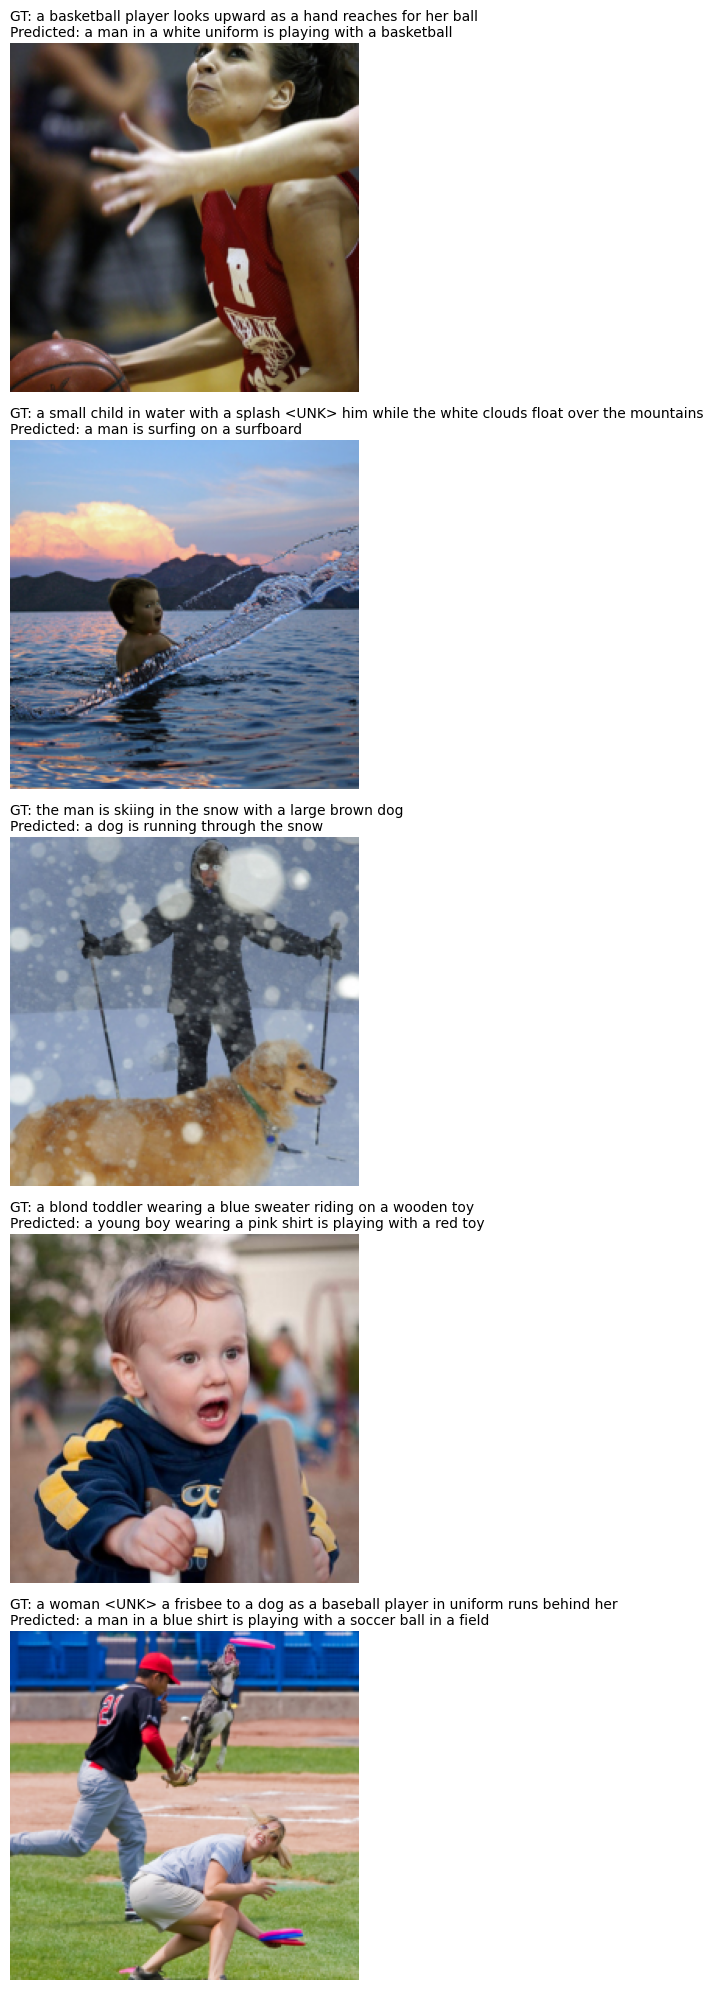

In [27]:
# Đánh giá trên Test Set với visualization
def visualize_predictions(model, dataset, vocab, device, num_samples=5):
    """
    Visualize ảnh và caption predictions
    """
    model.eval()

    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = [axes]

    # Random sample indices
    indices = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(indices):
        image, caption_tensor = dataset[idx]

        # Hiển thị ảnh
        # Chuyển từ tensor về numpy và đúng format
        img_display = image.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)

        axes[i].imshow(img_display)
        axes[i].axis('off')

        # Generate caption
        image_input = image.unsqueeze(0).to(device)
        generated_caption = model.generate_caption(image_input, vocab, max_length=30)

        # Ground truth
        gt_caption = vocab.denumericalize(caption_tensor)

        # Hiển thị captions
        title = f"GT: {gt_caption}\nPredicted: {generated_caption}"
        axes[i].set_title(title, fontsize=10, loc='left', wrap=True)

    plt.tight_layout()
    plt.show()

# Load best model
checkpoint = torch.load('best_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with val loss: {checkpoint['val_loss']:.4f}")

# Visualize predictions
visualize_predictions(model, test_dataset, vocab, device, num_samples=5)

In [28]:
# Tính BLEU score (đơn giản) để đánh giá chất lượng caption
from collections import Counter

def calculate_bleu_score(reference, candidate, n=4):
    """
    Tính BLEU score đơn giản
    reference: ground truth caption (string)
    candidate: generated caption (string)
    n: maximum n-gram
    """
    ref_tokens = reference.lower().split()
    cand_tokens = candidate.lower().split()

    if len(cand_tokens) == 0:
        return 0.0

    # Brevity penalty
    bp = min(1.0, np.exp(1 - len(ref_tokens) / max(len(cand_tokens), 1)))

    # N-gram precision
    precisions = []
    for i in range(1, n + 1):
        ref_ngrams = Counter([tuple(ref_tokens[j:j+i]) for j in range(len(ref_tokens)-i+1)])
        cand_ngrams = Counter([tuple(cand_tokens[j:j+i]) for j in range(len(cand_tokens)-i+1)])

        overlap = sum(min(cand_ngrams[ng], ref_ngrams[ng]) for ng in cand_ngrams)
        total = sum(cand_ngrams.values())

        if total == 0:
            precisions.append(0)
        else:
            precisions.append(overlap / total)

    # Geometric mean
    if 0 in precisions:
        return 0.0

    log_precision = sum(np.log(p) for p in precisions) / n
    bleu = bp * np.exp(log_precision)

    return bleu


def evaluate_on_test_set(model, dataset, vocab, device, num_samples=100):
    """
    Đánh giá model trên test set
    """
    model.eval()

    bleu_scores = []
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    print("Đang tính BLEU scores...")
    for idx in tqdm(indices):
        image, caption_tensor = dataset[idx]

        # Generate caption
        image_input = image.unsqueeze(0).to(device)
        generated_caption = model.generate_caption(image_input, vocab, max_length=30)

        # Ground truth
        gt_caption = vocab.denumericalize(caption_tensor)

        # Tính BLEU
        bleu = calculate_bleu_score(gt_caption, generated_caption, n=4)
        bleu_scores.append(bleu)

    avg_bleu = np.mean(bleu_scores)

    print(f"\n{'='*50}")
    print(f"EVALUATION RESULTS (on {len(bleu_scores)} samples)")
    print(f"{'='*50}")
    print(f"Average BLEU-4 Score: {avg_bleu:.4f}")
    print(f"Max BLEU-4 Score: {max(bleu_scores):.4f}")
    print(f"Min BLEU-4 Score: {min(bleu_scores):.4f}")
    print(f"Std BLEU-4 Score: {np.std(bleu_scores):.4f}")

    return bleu_scores

bleu_scores = evaluate_on_test_set(model, test_dataset, vocab, device, num_samples=100)

Đang tính BLEU scores...


100%|██████████| 100/100 [00:02<00:00, 43.16it/s]


EVALUATION RESULTS (on 100 samples)
Average BLEU-4 Score: 0.0146
Max BLEU-4 Score: 0.3741
Min BLEU-4 Score: 0.0000
Std BLEU-4 Score: 0.0648


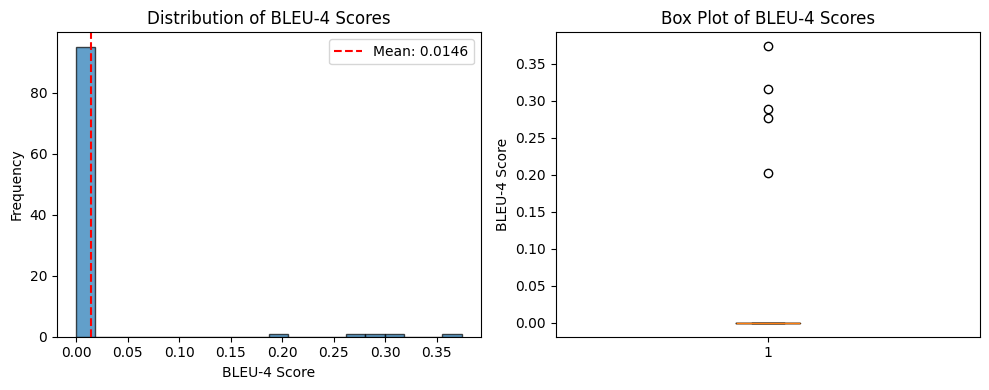

In [29]:
# Histogram of BLEU scores
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(bleu_scores, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('BLEU-4 Score')
plt.ylabel('Frequency')
plt.title('Distribution of BLEU-4 Scores')
plt.axvline(np.mean(bleu_scores), color='red', linestyle='--', label=f'Mean: {np.mean(bleu_scores):.4f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(bleu_scores)
plt.ylabel('BLEU-4 Score')
plt.title('Box Plot of BLEU-4 Scores')

plt.tight_layout()
plt.show()

# Demo: Generate Caption cho ảnh bất kỳ
Thử nghiệm model với ảnh từ test set

Image: 2742426734_291df6da08.jpg
Ground Truth Captions:
  1. A group of friends posing together in a park .
  2. A group of people posing for a picture on the grass .
  3. A group of people posing for a picture with the sun behind them .
  4. A group of young people pose for a picture in a field
  5. Young people pose for their picture in the countryside .



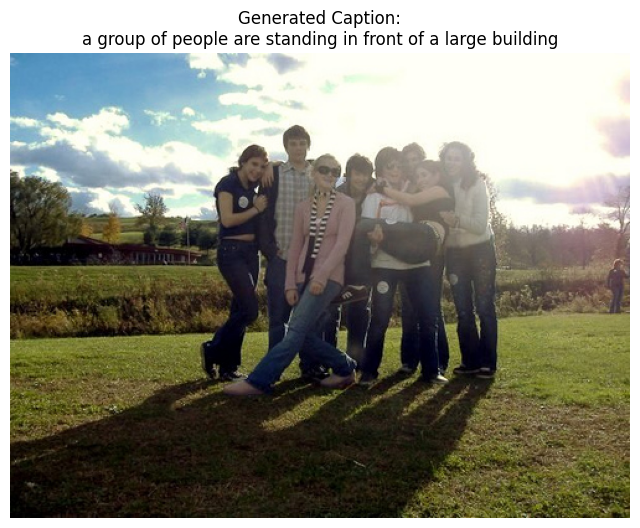


Generated Caption: a group of people are standing in front of a large building


In [30]:
def predict_caption(image_path, model, vocab, transform, device):
    """
    Predict caption cho một ảnh từ đường dẫn
    """
    model.eval()

    # Load và transform ảnh
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Generate caption
    caption = model.generate_caption(image_tensor, vocab, max_length=30)

    # Hiển thị
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Generated Caption:\n{caption}", fontsize=12)
    plt.show()

    return caption


# Demo với một ảnh random từ test set
sample_path = list(test_data.keys())[random.randint(0, len(test_data)-1)]
full_path = os.path.join(images_path, sample_path)

print(f"Image: {sample_path}")
print(f"Ground Truth Captions:")
for i, cap in enumerate(test_data[sample_path], 1):
    print(f"  {i}. {cap}")
print()

generated = predict_caption(full_path, model, vocab, transform_keep_ratio, device)
print(f"\nGenerated Caption: {generated}")